In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ods_ai_geo.zip'

Archive:  /content/drive/MyDrive/ods_ai_geo.zip
   creating: ods_ai_geo/
  inflating: ods_ai_geo/df_test.csv  
  inflating: ods_ai_geo/df_train.csv  
  inflating: ods_ai_geo/sample_submission_1.csv  


In [ ]:
!pip uninstall scikit-learn -y
!pip install -U -q scikit-learn

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.8 MB/s eta 0:00:00


In [ ]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install -q osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely import wkt
import seaborn as sns

In [ ]:
train = pd.read_csv("/content/ods_ai_geo/df_train.csv")
test = pd.read_csv("/content/ods_ai_geo/df_test.csv")
submit = pd.read_csv("/content/ods_ai_geo/sample_submission_1.csv")

In [ ]:
train.head()

,Unnamed: 0,latitude,longitude,city,area,area_kitchen,rooms_num,has_balcony,price
0,0,53.2117,50.1669,Самара,33.9,8.0,1,True,2473000
1,1,45.0389,39.0985,Краснодар,49.8,12.0,2,True,3733000
2,2,45.0694,38.9716,Краснодар,45.1,25.1,2,True,3445000
3,3,53.2164,50.2605,Самара,70.1,10.0,3,True,4458000
4,4,53.1651,50.3842,Самара,34.0,NaN,1,True,1295000


In [ ]:
test.head()

,Unnamed: 0,latitude,longitude,city,area,area_kitchen,rooms_num,has_balcony
0,0,45.0164,39.0467,Краснодар,67.1,NaN,2,True
1,1,45.0729,39.0407,Краснодар,84.1,15.1,3,False
2,2,45.0903,39.0325,Краснодар,34.9,10.0,1,True
3,3,45.1010,38.9272,Краснодар,31.1,8.8,1,True
4,4,45.0751,38.9052,Краснодар,22.9,3.0,1,True


In [ ]:
train_latitude = train['latitude']
train_longitude = train['longitude']

test_latitude = test['latitude']
test_longitude = test['longitude']

In [ ]:
train.shape, test.shape

((8042, 9), (3443, 8))

In [ ]:
train.isna().sum()

,0
Unnamed: 0,0
latitude,0
longitude,0
city,0
area,0
area_kitchen,802
rooms_num,0
has_balcony,0
price,0


In [ ]:
test.isna().sum()

,0
Unnamed: 0,0
latitude,0
longitude,0
city,0
area,0
area_kitchen,316
rooms_num,0
has_balcony,0


In [ ]:
train.loc[train['area_kitchen'].isna(), 'is_apart'] = 1
train['is_apart'] = train['is_apart'].fillna(0)
test.loc[test['area_kitchen'].isna(), 'is_apart'] = 1
test['is_apart'] = test['is_apart'].fillna(0)

In [ ]:
train.loc[:, 'has_balcony'] = train.loc[:, 'has_balcony'].astype('int')
test.loc[:, 'has_balcony'] = test.loc[:, 'has_balcony'].astype('int')

In [ ]:
# train.columns.values[0] = 'id'
# test.columns.values[0] = 'id'
train = train.drop(train.columns.values[0], axis=1)
test = test.drop(test.columns.values[0], axis=1)

In [ ]:
train["geometry"] = gpd.points_from_xy(
    x=train["longitude"], y=train["latitude"], crs="EPSG:4326"
)
test["geometry"] = gpd.points_from_xy(
    x=test["longitude"], y=test["latitude"], crs="EPSG:4326"
)

In [ ]:
gdf_train = gpd.GeoDataFrame(train)
gdf_test = gpd.GeoDataFrame(test)

In [ ]:
gdf_train = gdf_train.drop(['latitude', 'longitude'], axis=1)
gdf_test = gdf_test.drop(['latitude', 'longitude'], axis=1)

In [ ]:
gdf_train.head()

,city,area,area_kitchen,rooms_num,has_balcony,price,is_apart,geometry
0,Самара,33.9,8.0,1,1,2473000,0.0,POINT (50.16690 53.21170)
1,Краснодар,49.8,12.0,2,1,3733000,0.0,POINT (39.09850 45.03890)
2,Краснодар,45.1,25.1,2,1,3445000,0.0,POINT (38.97160 45.06940)
3,Самара,70.1,10.0,3,1,4458000,0.0,POINT (50.26050 53.21640)
4,Самара,34.0,NaN,1,1,1295000,1.0,POINT (50.38420 53.16510)


# Prepare files:

In [ ]:
# Предлагаю сразу задать графы для наших городов, чтобы не "подтягивать" их для
# каждой строки датасета
city_1 = ox.geocode_to_gdf(['Россия, Краснодар'])
polygon_1 = city_1.iloc[0]['geometry']
G_krasnodar = ox.graph_from_polygon(polygon_1, network_type="drive", simplify=True)
G_krasnodar = ox.project_graph(G_krasnodar)
nodes_1, edges_1 = ox.graph_to_gdfs(G_krasnodar)

In [ ]:
city_2 = ox.geocode_to_gdf(['Россия, город Нижний Новгород'])
polygon_2 = city_2.iloc[0]['geometry']
G_nignii_novgorod = ox.graph_from_polygon(polygon_2, network_type="drive", simplify=True)
G_nignii_novgorod = ox.project_graph(G_nignii_novgorod)
nodes_2, edges_2 = ox.graph_to_gdfs(G_nignii_novgorod)

In [ ]:
city_3 = ox.geocode_to_gdf(['Россия, Самара'])
polygon_3 = city_3.iloc[0]['geometry']
G_samara = ox.graph_from_polygon(polygon_3, network_type="drive", simplify=True)
G_samara = ox.project_graph(G_samara)
nodes_3, edges_3 = ox.graph_to_gdfs(G_samara)

In [ ]:
# И найдем ручками координаты центров, по той же причине
admin_krasnodar = ox.features.features_from_place('Россия, Краснодар',
                                                  tags={'amenity': 'townhall'})
admin_krasnodar_point = (
    admin_krasnodar
    .to_crs(edges_1.crs)
    .loc[('node', 2126162731), 'geometry']
    .centroid
)
print(admin_krasnodar_point)

POINT (498057.302201348 4986823.01211868)


In [ ]:
admin_nignii_novgorod = ox.features.features_from_place('Россия, Администрация Нижнего Новгорода',
                                                        tags={'amenity': 'townhall'})
admin_nignii_novgorod_point = (
    admin_nignii_novgorod
    .to_crs(edges_2.crs)
    .loc[('relation', 2917119), 'geometry']
    .centroid
)
print(admin_nignii_novgorod_point)

POINT (438497.36621953786 6243139.975165727)


In [ ]:
admin_samara = ox.features.features_from_place('Россия, Администрация Самара',
                                               tags={'amenity': 'townhall'})
admin_samara_point = (
    admin_samara
    .to_crs(edges_3.crs)
    .loc[('way', 133296416), 'geometry']
    .centroid
)
print(admin_samara_point)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


POINT (439442.45885879605 5894134.74374305)


In [ ]:
# Функция для вычисления расстояния по автодорожной сети
def get_driving_distance(G, orig_point, dest_point):
    try:
        orig_node = ox.distance.nearest_nodes(G, orig_point.x, orig_point.y)
        dest_node = ox.distance.nearest_nodes(G, dest_point.x, dest_point.y)
        length = nx.shortest_path_length(G, orig_node, dest_node, weight='length')

        return int(length)

    except Exception as e:
        print(f"Ошибка расчета расстояния: {e}")

        return -1 # пометим все ошибки

In [ ]:
# Добавляем новые колонки
gdf_train['is_central_district'] = 0
gdf_train['length_from_central'] = 0
gdf_test['is_central_district'] = 0
gdf_test['length_from_central'] = 0

In [ ]:
# Функция для добавления новых признаков
def add_new_features(gdf):
    gdf_temp = gdf.copy()
    # Проходим по каждой квартире в датасете
    for idx, row in gdf_temp.iterrows():
        city_name = row['city']
        # Создаем геосерию, чтобы изменить CRS
        flat_coords = gpd.GeoSeries(row['geometry'], crs="EPSG:4326")

        # Для каждого города свой граф и свои координаты администрации
        if city_name == 'Краснодар':
            admin_coords = admin_krasnodar_point
            flat_coords = flat_coords.to_crs(edges_1.crs)[0]
            G = G_krasnodar
        elif city_name == 'Нижний Новгород':
            admin_coords = admin_nignii_novgorod_point
            flat_coords = flat_coords.to_crs(edges_2.crs)[0]
            G = G_nignii_novgorod
        elif city_name == 'Самара':
            admin_coords = admin_samara_point
            flat_coords = flat_coords.to_crs(edges_3.crs)[0]
            G = G_samara

        # Вычисляем расстояние
        distance = get_driving_distance(G, flat_coords, admin_coords)
        gdf_temp.loc[idx, 'length_from_central'] = distance

        # Определяем, находится ли квартира в радиусе 1 км от администрации
        if distance != -1 and distance <= 1000:
            gdf_temp.loc[idx, 'is_central_district'] = 1

    return gdf_temp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gdf_train = add_new_features(gdf_train)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
gdf_test = add_new_features(gdf_test)

/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 583371191


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 583371191


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 3515184693


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 574620251


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248
Ошибка расчета расстояния: Node 295170192 not reachable from 3515184693


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 574620251


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 4576737016


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 295171337


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 583371191


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 7656258248


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 356191398


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 295170192 not reachable from 3515184693


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 3782990445 not reachable from 597712746


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

Ошибка расчета расстояния: Node 3782990445 not reachable from 597712746


/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/

In [ ]:
gdf_train.to_csv("gdf_train_v1.csv")
gdf_test.to_csv("gdf_test_v1.csv")

# Fill missing values:

In [ ]:
gdf_train = pd.read_csv('/content/drive/MyDrive/gdf_train_v1.csv', index_col=[0])
gdf_test = pd.read_csv('/content/drive/MyDrive/gdf_test_v1.csv', index_col=[0])

gdf_train['geometry'] = gdf_train['geometry'].apply(wkt.loads)
gdf_test['geometry'] = gdf_test['geometry'].apply(wkt.loads)

gdf_train = gpd.GeoDataFrame(gdf_train, geometry='geometry', crs=4326)
gdf_test = gpd.GeoDataFrame(gdf_test, geometry='geometry', crs=4326)

In [ ]:
# cat_data = ['city', 'rooms_num', 'has_balcony', 'is_central_district']
# num_data = ['area', 'area_kitchen', 'length_from_central']

In [ ]:
# Особое отношение требует данная колонка
gdf_train['is_apart'] = gdf_train['is_apart'].astype('int')
gdf_test['is_apart'] = gdf_test['is_apart'].astype('int')

In [ ]:
# gdf_train[cat_data]  = gdf_train[cat_data].astype('category')
# gdf_test[cat_data]  = gdf_test[cat_data].astype('category')

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
imp_mean.fit(gdf_train[['area_kitchen']])

SimpleImputer()

In [ ]:
gdf_train['area_kitchen'] = imp_mean.transform(gdf_train[['area_kitchen']])

In [ ]:
gdf_test['area_kitchen'] = imp_mean.transform(gdf_test[['area_kitchen']])

In [ ]:
gdf_train.head()

,city,area,area_kitchen,rooms_num,has_balcony,price,is_apart,geometry,is_central_district,length_from_central
0,Самара,33.9,8.00000,1,1,2473000,0,POINT (50.16690 53.21170),0,6506
1,Краснодар,49.8,12.00000,2,1,3733000,0,POINT (39.09850 45.03890),0,10996
2,Краснодар,45.1,25.10000,2,1,3445000,0,POINT (38.97160 45.06940),0,4190
3,Самара,70.1,10.00000,3,1,4458000,0,POINT (50.26050 53.21640),0,12957
4,Самара,34.0,11.05692,1,1,1295000,1,POINT (50.38420 53.16510),0,-1


In [ ]:
train = gdf_train.copy()
test = gdf_test.copy()

In [ ]:
train['latitude'] = train_latitude
train['longitude'] = train_longitude

test['latitude'] = test_latitude
test['longitude'] = test_longitude

Extra features:

In [ ]:
# train['mean_price_rooms'] = train.groupby('rooms_num')['price'].transform('mean')
# test['mean_price_rooms'] = test.groupby('rooms_num')['price'].transform('mean')

In [ ]:
train['mean_area_city'] = train.groupby('city')['area'].transform('mean')
test['mean_area_city'] = test.groupby('city')['area'].transform('mean')

In [ ]:
train['mean_area_rooms'] = train.groupby('rooms_num')['area'].transform('mean')
test['mean_area_rooms'] = test.groupby('rooms_num')['area'].transform('mean')

In [ ]:
train['mean_area_kitchen'] = train.groupby('rooms_num')['area_kitchen'].transform('mean')
test['mean_area_kitchen'] = test.groupby('rooms_num')['area_kitchen'].transform('mean')

In [ ]:
train['room_ratio'] = train['area_kitchen'] / train['area']
test['room_ratio'] = test['area_kitchen'] / test['area']

In [ ]:
train['latitude_std'] = train.groupby('city')['latitude'].transform('std')
train['longitude_std'] = train.groupby('city')['longitude'].transform('std')

test['latitude_std'] = test.groupby('city')['latitude'].transform('std')
test['longitude_std'] = test.groupby('city')['longitude'].transform('std')

In [ ]:
train['area_max'] = train.groupby('city')['area'].transform('max')
test['area_max'] = test.groupby('city')['area'].transform('max')

In [ ]:
cols2drop = ['is_apart', 'geometry']

In [ ]:
train = train.drop(cols2drop, axis=1)
test = test.drop(cols2drop, axis=1)

In [ ]:
train.head()

,city,area,area_kitchen,rooms_num,has_balcony,price,is_central_district,length_from_central,latitude,longitude,mean_area_city,mean_area_rooms,mean_area_kitchen,room_ratio,latitude_std,longitude_std,area_max
0,Самара,33.9,8.00000,1,1,2473000,0,6506,53.2117,50.1669,52.172328,35.686218,10.187484,0.235988,0.058027,0.06682,356.1
1,Краснодар,49.8,12.00000,2,1,3733000,0,10996,45.0389,39.0985,51.164584,55.332951,10.978901,0.240964,0.037551,0.06034,1000.0
2,Краснодар,45.1,25.10000,2,1,3445000,0,4190,45.0694,38.9716,51.164584,55.332951,10.978901,0.556541,0.037551,0.06034,1000.0
3,Самара,70.1,10.00000,3,1,4458000,0,12957,53.2164,50.2605,52.172328,78.158533,12.537515,0.142653,0.058027,0.06682,356.1
4,Самара,34.0,11.05692,1,1,1295000,0,-1,53.1651,50.3842,52.172328,35.686218,10.187484,0.325204,0.058027,0.06682,356.1


In [ ]:
test.head()

,city,area,area_kitchen,rooms_num,has_balcony,is_central_district,length_from_central,latitude,longitude,mean_area_city,mean_area_rooms,mean_area_kitchen,room_ratio,latitude_std,longitude_std,area_max
0,Краснодар,67.1,11.05692,2,1,0,6798,45.0164,39.0467,50.230349,55.918020,11.049881,0.164783,0.037972,0.060837,320.1
1,Краснодар,84.1,15.10000,3,0,0,8955,45.0729,39.0407,50.230349,75.354400,12.387077,0.179548,0.037972,0.060837,320.1
2,Краснодар,34.9,10.00000,1,1,0,10392,45.0903,39.0325,50.230349,35.484379,10.159173,0.286533,0.037972,0.060837,320.1
3,Краснодар,31.1,8.80000,1,1,0,11840,45.1010,38.9272,50.230349,35.484379,10.159173,0.282958,0.037972,0.060837,320.1
4,Краснодар,22.9,3.00000,1,1,0,8131,45.0751,38.9052,50.230349,35.484379,10.159173,0.131004,0.037972,0.060837,320.1


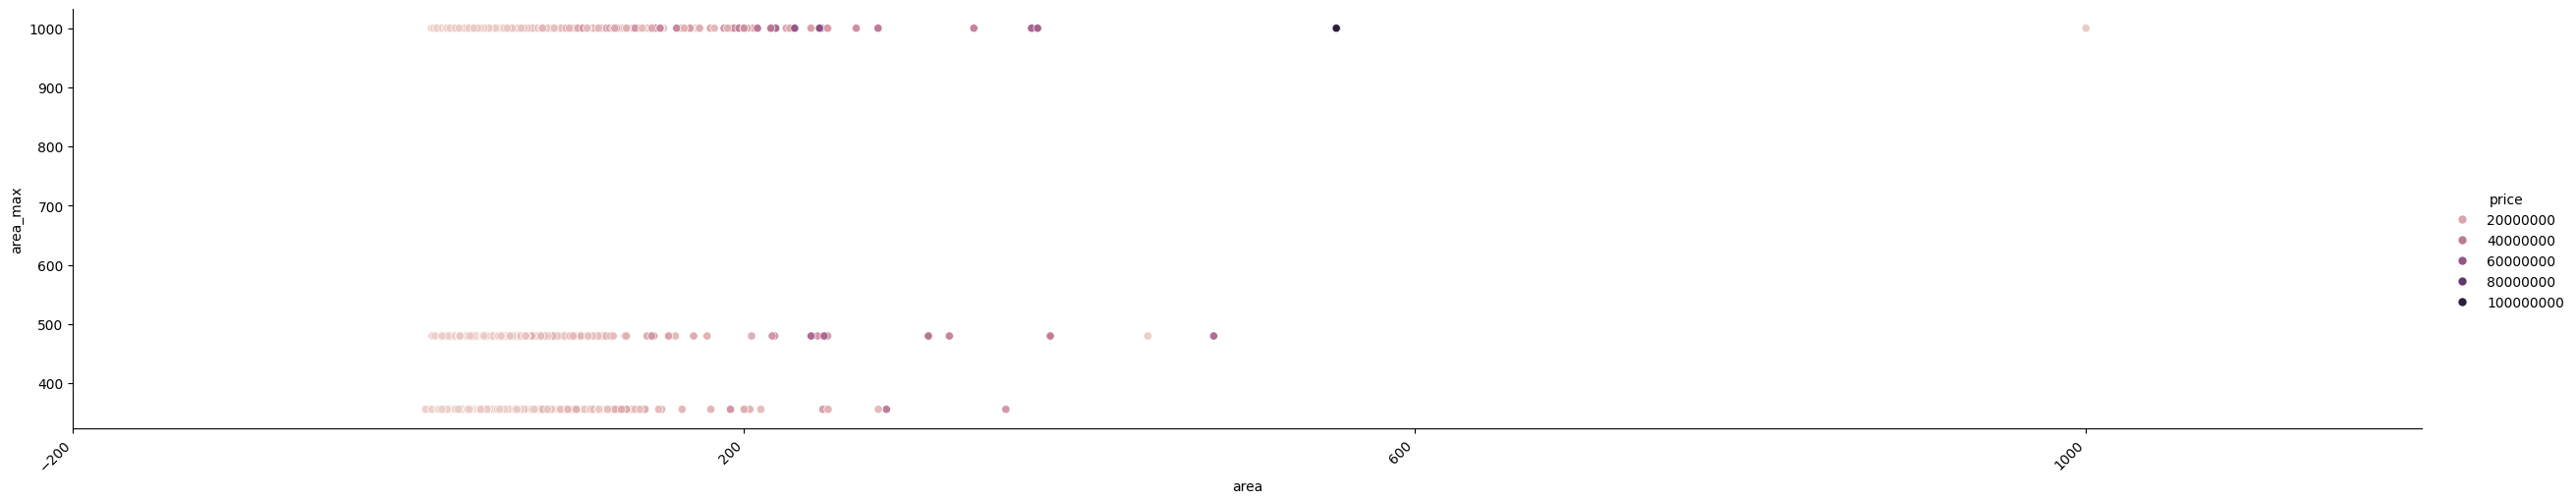

In [ ]:
g = sns.relplot(
    data=train,
    x="area",
    y="area_max",
    hue="price",
    kind="scatter",
    aspect=5,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

In [ ]:
train.corr(numeric_only=True)

,area,area_kitchen,rooms_num,has_balcony,price,is_central_district,length_from_central,latitude,longitude,mean_area_city,mean_area_rooms,mean_area_kitchen,room_ratio,latitude_std,longitude_std,area_max
area,1.000000,0.519887,0.380642,0.065719,0.776607,0.120835,-0.198206,0.045542,0.023787,0.052750,0.718977,0.684197,-0.342276,0.002715,0.052284,-0.036073
area_kitchen,0.519887,1.000000,0.144446,0.127093,0.556435,0.048895,-0.174284,-0.218406,-0.197733,-0.174375,0.271464,0.285263,0.428722,-0.144630,-0.190848,0.218355
rooms_num,0.380642,0.144446,1.000000,0.003233,0.267577,0.029086,-0.042942,0.088169,0.059440,0.088340,0.529422,0.506362,-0.226523,0.027224,0.090571,-0.076980
has_balcony,0.065719,0.127093,0.003233,1.000000,0.109590,-0.086883,0.002998,-0.217634,-0.177167,-0.191301,-0.027824,-0.017995,0.059307,-0.113781,-0.203413,0.206756
price,0.776607,0.556435,0.267577,0.109590,1.000000,0.174078,-0.350404,-0.087051,-0.137720,-0.019886,0.537596,0.540380,-0.188291,-0.144440,-0.038754,0.118376
is_central_district,0.120835,0.048895,0.029086,-0.086883,0.174078,1.000000,-0.197178,0.007148,0.019246,-0.004603,0.085895,0.080110,-0.060136,0.024284,-0.001307,-0.014766
length_from_central,-0.198206,-0.174284,-0.042942,0.002998,-0.350404,-0.197178,1.000000,0.170355,0.224091,0.074341,-0.112543,-0.107410,0.040041,0.215803,0.101832,-0.205705
latitude,0.045542,-0.218406,0.088169,-0.217634,-0.087051,0.007148,0.170355,1.000000,0.813608,0.878454,0.179151,0.141010,-0.330850,0.522321,0.934048,-0.949305
longitude,0.023787,-0.197733,0.059440,-0.177167,-0.137720,0.019246,0.224091,0.813608,1.000000,0.437135,0.131520,0.100301,-0.281254,0.920577,0.552526,-0.955057
mean_area_city,0.052750,-0.174375,0.088340,-0.191301,-0.019886,-0.004603,0.074341,0.878454,0.437135,1.000000,0.170072,0.136524,-0.282105,0.051472,0.991168,-0.683862


# Cat Boost:

In [ ]:
cat_features = ['city']
target = ['price']

In [ ]:
X = train.drop(target, axis=1, errors="ignore")
y = train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = CatBoostRegressor(thread_count=-1,
                        iterations=100,
                        random_seed=42,
                        cat_features=cat_features,
                        eval_metric="RMSE",
                        loss_function='RMSE')

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.277854
0:	learn: 3482143.5796746	test: 3722272.0796208	best: 3722272.0796208 (0)	total: 51.5ms	remaining: 5.1s
99:	learn: 884718.8422674	test: 1531608.3242434	best: 1520351.9746462 (62)	total: 420ms	remaining: 0us

bestTest = 1520351.975
bestIteration = 62

Shrink model to first 63 iterations.


In [ ]:
preds_cat = clf.predict(test)

In [ ]:
title = "submission_cat2.csv"
# ans = pd.DataFrame(preds, columns = ['price'])
# ans.to_csv(title, index=False)
submit['price'] = preds_cat
submit.to_csv(title, index=False)

# Optimal Parameters:

In [ ]:
n_splits = 10
clfs = []
scores = []

X = train.drop(target, axis=1, errors="ignore")
y = train[target]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostRegressor(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        eval_metric = 'RMSE',
        cat_features=cat_features,
        # ignored_features = ignored_features,

        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,

        task_type="CPU",
        thread_count=-1,
        bootstrap_type="Bernoulli",

        random_seed=7575,
        # auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "RMSE" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean Recall score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 4217140.6790672	test: 4512283.2929622	best: 4512283.2929622 (0)	total: 13.5ms	remaining: 47.2s
500:	learn: 1483030.3088834	test: 1638777.7007462	best: 1638777.7007462 (500)	total: 2s	remaining: 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1610233.298
bestIteration = 598

Shrink model to first 599 iterations.
0:	learn: 4179325.9510555	test: 4818705.2762375	best: 4818705.2762375 (0)	total: 2.89ms	remaining: 10.1s


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


500:	learn: 1495393.6120847	test: 1856322.7250606	best: 1856322.7250606 (500)	total: 1.55s	remaining: 9.3s
1000:	learn: 1294569.5116991	test: 1740668.9238706	best: 1740668.9238706 (1000)	total: 2.64s	remaining: 6.59s
1500:	learn: 1189923.6964315	test: 1686382.8342568	best: 1685199.4510036 (1487)	total: 3.49s	remaining: 4.64s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1676105.853
bestIteration = 1570

Shrink model to first 1571 iterations.
0:	learn: 4286932.4552419	test: 3875489.0194489	best: 3875489.0194489 (0)	total: 1.11ms	remaining: 3.88s
500:	learn: 1527962.2739863	test: 1667177.2402189	best: 1667177.2402189 (500)	total: 465ms	remaining: 2.79s
1000:	learn: 1323185.2970456	test: 1586582.7808555	best: 1585347.9865009 (990)	total: 948ms	remaining: 2.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1566584.387
bestIteration = 1237

Shrink model to first 1238 iterations.
0:	learn: 4172226.5357993	test: 4874253.6071953	best: 4874253.6071953 (0)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
clf.get_params()

{'iterations': 3500,
 'learning_rate': 0.06,
 'depth': 4,
 'l2_leaf_reg': 9,
 'loss_function': 'RMSE',
 'random_seed': 7575,
 'random_strength': 1,
 'eval_metric': 'RMSE',
 'task_type': 'CPU',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.95,
 'colsample_bylevel': 0.098,
 'max_bin': 187,
 'early_stopping_rounds': 50,
 'cat_features': ['city'],
 'min_data_in_leaf': 243}

In [ ]:
clf_opt = CatBoostRegressor(**clf.get_params())

clf_opt.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

0:	learn: 4295792.0109003	test: 3786078.9941607	best: 3786078.9941607 (0)	total: 706us	remaining: 2.47s
200:	learn: 1875114.2671556	test: 1671994.2489505	best: 1671994.2489505 (200)	total: 202ms	remaining: 3.31s
400:	learn: 1571062.5540347	test: 1438347.0349936	best: 1438347.0349936 (400)	total: 388ms	remaining: 3s
600:	learn: 1450794.8864559	test: 1368883.9603728	best: 1368883.9603728 (600)	total: 585ms	remaining: 2.82s
800:	learn: 1382131.6764742	test: 1330006.3409323	best: 1329898.0758841 (794)	total: 780ms	remaining: 2.63s
1000:	learn: 1325185.2338363	test: 1304003.7515077	best: 1304003.7515077 (1000)	total: 967ms	remaining: 2.42s
1200:	learn: 1272784.3527058	test: 1275088.1206353	best: 1274852.2771836 (1194)	total: 1.18s	remaining: 2.26s
1400:	learn: 1229070.1178096	test: 1256542.0076364	best: 1256356.7461660 (1395)	total: 1.38s	remaining: 2.06s
1600:	learn: 1190178.0228221	test: 1237334.6674050	best: 1237334.6674050 (1600)	total: 1.58s	remaining: 1.87s
1800:	learn: 1164959.683694

In [ ]:
clf_opt.get_feature_importance(prettified=True)

,Feature Id,Importances
0,area,31.307698
1,area_kitchen,14.170673
2,length_from_central,11.912078
3,rooms_num,7.398734
4,mean_area_kitchen,7.291118
5,latitude,6.947370
6,longitude,5.803185
7,mean_area_rooms,5.066451
8,room_ratio,3.712683
9,has_balcony,1.431086


In [ ]:
preds = clf_opt.predict(test)

In [ ]:
title = "submission_catboost5.csv"
submit['price'] = preds
submit.to_csv(title, index=False)

# XGBoost

In [ ]:
cat_features = ['city']
target = ['price']
# features2drop = ['mean_area_kitchen', 'is_central_district']

In [ ]:
X = train.drop(target, axis=1, errors="ignore")
# X = X.drop(features2drop, axis=1, errors="ignore")
y = train[target]

for col in cat_features:
    X[col] = X[col].astype('category')
    test[col] = test[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     nthread=-1,
                     enable_categorical=True)

dtest = xgb.DMatrix(X_test,
                    y_test,
                    nthread=-1,
                    enable_categorical=True)

In [ ]:
iters = 500
learning_rates = np.linspace(0.3, 0.005, iters).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed': 42,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=iters,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    callbacks=[scheduler],
                    early_stopping_rounds=10,
                    verbose_eval=5)

[0]	dtrain-rmse:3205185.88482	dtest-rmse:3418894.72564
[5]	dtrain-rmse:1362690.12475	dtest-rmse:1968777.27585
[10]	dtrain-rmse:1027183.97877	dtest-rmse:1926086.97784
[15]	dtrain-rmse:900942.64744	dtest-rmse:1888901.32952
[20]	dtrain-rmse:837337.01149	dtest-rmse:1879426.80754
[25]	dtrain-rmse:781874.17879	dtest-rmse:1867709.50584
[30]	dtrain-rmse:734419.52812	dtest-rmse:1850521.83077
[35]	dtrain-rmse:694858.02477	dtest-rmse:1842173.73769
[40]	dtrain-rmse:654310.02635	dtest-rmse:1841366.51322
[45]	dtrain-rmse:633368.63903	dtest-rmse:1843987.73132


In [ ]:
y_pred = booster.predict(dtest,
                         iteration_range=(0, booster.best_iteration + 1))
root_mean_squared_error(y_test, y_pred)

1838716.7605987773

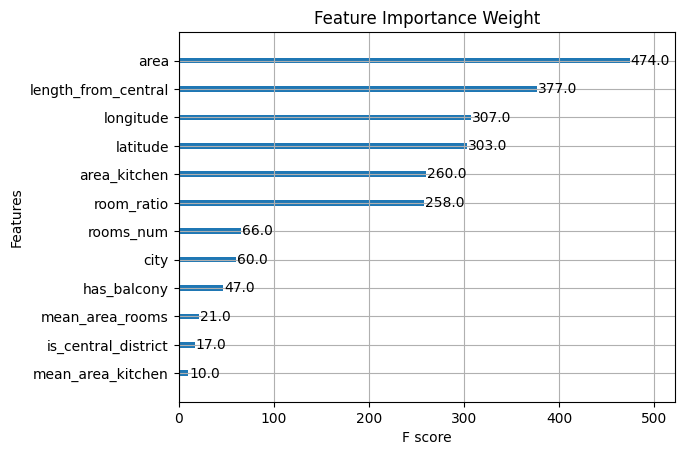

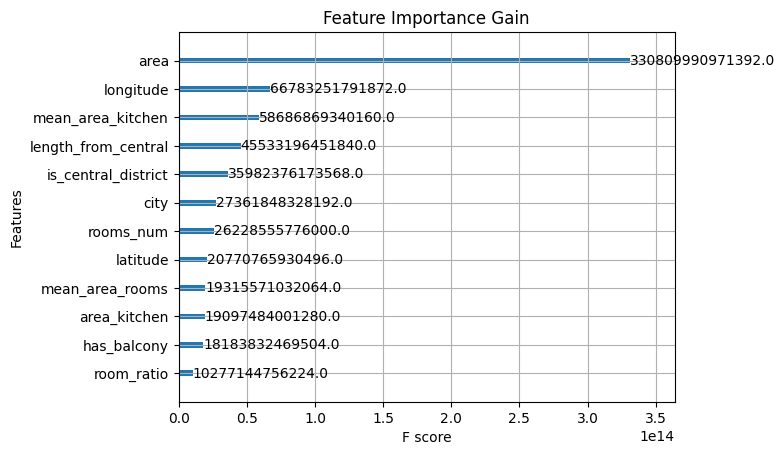

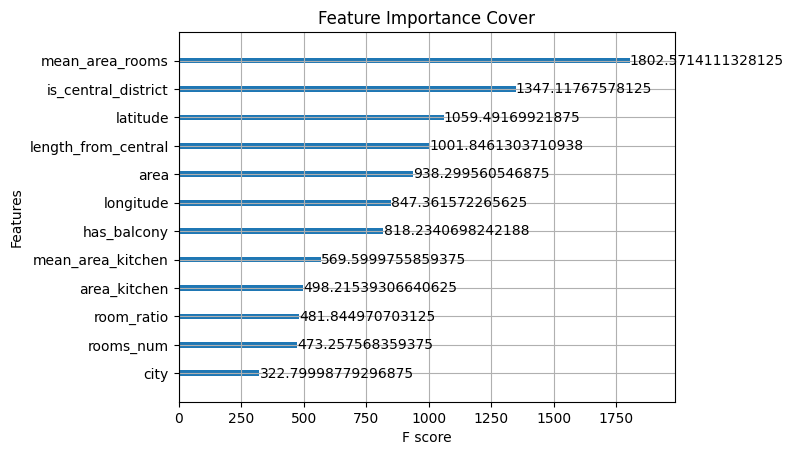

In [ ]:
xgb.plot_importance(booster, title='Feature Importance Weight')
xgb.plot_importance(booster, importance_type='gain', title='Feature Importance Gain')
xgb.plot_importance(booster, importance_type='cover', title='Feature Importance Cover');

In [ ]:
dtest_test = xgb.DMatrix(test,
                    nthread=-1,
                    enable_categorical=True)

In [ ]:
preds_xgb = booster.predict(dtest_test,
                         iteration_range=(0, booster.best_iteration + 1))

In [ ]:
preds_xgb

array([ 8073458. ,  7502976.5,  3474396. , ...,  3122127. , 14061042. ,
        6090881.5], dtype=float32)

In [ ]:
title = "submission_xgb4.csv"
# ans = pd.DataFrame(preds, columns = ['price'])
# ans.to_csv(title, index=False)
submit['price'] = preds_xgb
submit.to_csv(title, index=False)